In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb

keras = tf.keras

print("Tensorflow Version: " + tf.VERSION)

Tensorflow Version: 1.13.1


# IMDB Dataset 
https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

In [2]:
# imdb data
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
              num_words=None,
              skip_top=0,
              maxlen=None,
              seed=113,
              start_char=1,
              oov_char=2,
              index_from=3)

# word index
word_index = imdb.get_word_index()
word_index_inv = {v: k for k, v in word_index.items()}
word_index_inv[0] = "<PAD/>"

def encoded_vector2sentence(vec, word_index_inv = word_index_inv):
    sentence = map(lambda i: word_index_inv[i], vec)
    return " ".join(sentence)

def pad_input(vec, maxlen):
    return keras.preprocessing.sequence.pad_sequences(vec, maxlen=maxlen, padding='post')

def sentence2encoded_vec(sentence):
    sentence_arr = sentence.split(" ")
    return list(map(lambda word: word_index[word.lower()], sentence_arr))

In [3]:
# raw data representation
print(x_train[0], y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1


In [4]:
# parsed sentence
print(encoded_vector2sentence(x_train[0]))

the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but whe

In [5]:
# Max Input Length
max_length = max(map(lambda vec: len(vec), x_train + x_test))

# pad input vectors
x_train_padded = pad_input(x_train, max_length)
x_test_padded = pad_input(x_test, max_length)
x_train_padded[0]

array([ 1, 14, 22, ...,  0,  0,  0])

In [6]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
model = keras.Sequential([
    keras.layers.Embedding(len(word_index), 3, input_length=max_length),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2697, 3)           265752    
_________________________________________________________________
flatten (Flatten)            (None, 8091)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8092      
Total params: 273,844
Trainable params: 273,844
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
tb_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,  
          write_graph=True, write_images=True)

model.fit(x_train_padded, y_train, epochs=10, callbacks=[tb_callback])
loss, accuracy = model.evaluate(x_train_padded, y_train)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % loss)

Epoch 1/10
25000/25000 [==============================] - 3s 129us/sample - loss: 3.1897e-04 - acc: 1.0000
Epoch 2/10
25000/25000 [==============================] - 3s 129us/sample - loss: 2.2114e-04 - acc: 1.0000
Epoch 3/10
25000/25000 [==============================] - 4s 142us/sample - loss: 1.5185e-04 - acc: 1.0000
Epoch 4/10
25000/25000 [==============================] - 4s 163us/sample - loss: 1.0453e-04 - acc: 1.0000
Epoch 5/10
25000/25000 [==============================] - 3s 139us/sample - loss: 7.2654e-05 - acc: 1.0000
Epoch 6/10
25000/25000 [==============================] - 4s 148us/sample - loss: 4.9754e-05 - acc: 1.0000
Epoch 7/10
25000/25000 [==============================] - 3s 133us/sample - loss: 3.4668e-05 - acc: 1.0000
Epoch 8/10
25000/25000 [==============================] - 3s 124us/sample - loss: 2.3881e-05 - acc: 1.0000
Epoch 9/10
25000/25000 [==============================] - 3s 126us/sample - loss: 1.6661e-05 - acc: 1.0000
Epoch 10/10
25000/25000 [============

TypeError: evaluate() got an unexpected keyword argument 'callbacks'

In [8]:
def test_model(x, y):
    test_result = np.round(model.predict(x))
    test_errors = np.squeeze(test_result) != y
    correct_percentage = np.sum(test_errors) / len(y)
    print("%i / %i (%.2f%%) are correct" % (len(y) - np.sum(test_errors), len(y), 100 * (1 - correct_percentage)))

In [17]:
test_model(x_test_padded, y_test)

20946 / 25000 (83.78%) are correct


In [18]:
sample_vecs = pad_input([sentence2encoded_vec("I good thing")], max_length)
test_model(sample_vecs, [[0]])

1 / 1 (100.00%) are correct


<IPython.core.display.Javascript object>


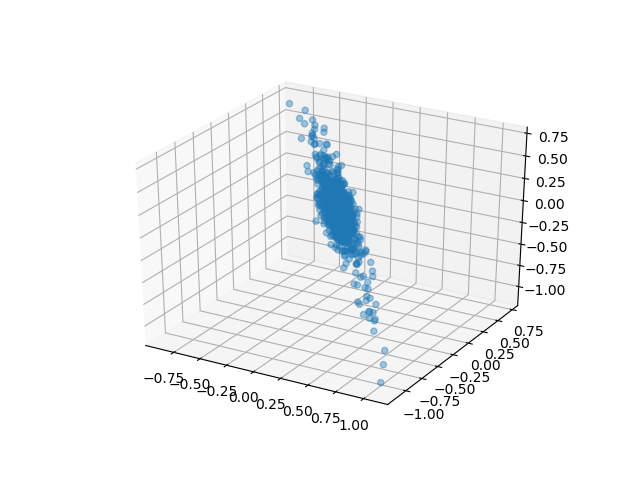

In [13]:
embeding_weights = model.layers[0].get_weights()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.transpose(embeding_weights)[0][:1000]
y = np.transpose(embeding_weights)[1][:1000]
z = np.transpose(embeding_weights)[2][:1000]
ax.scatter(x, y, z, alpha=0.4)